# 1. Исследовательский анализ данных

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## Анализ данных

In [5]:
print('Количество файлов', labels.shape[0])

Количество файлов 7591


<hr>

Распределение возрасатов в выборке

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53d5e82ed0>]],
      dtype=object)

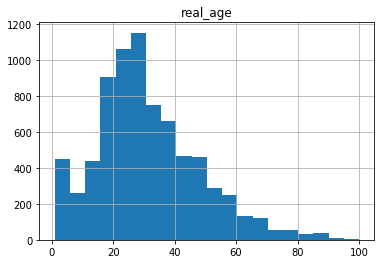

In [6]:
labels.hist(bins=20)

Получим первую пачку картинок:

In [7]:
train_data = train_gen_flow.next()

Взглянем на пачку

In [8]:
print('Картинки:', train_data[0].shape)
print('Целевой признац:', train_data[1].shape)

Картинки: (32, 224, 224, 3)
Целевой признац: (32,)


Выведем 15 фото

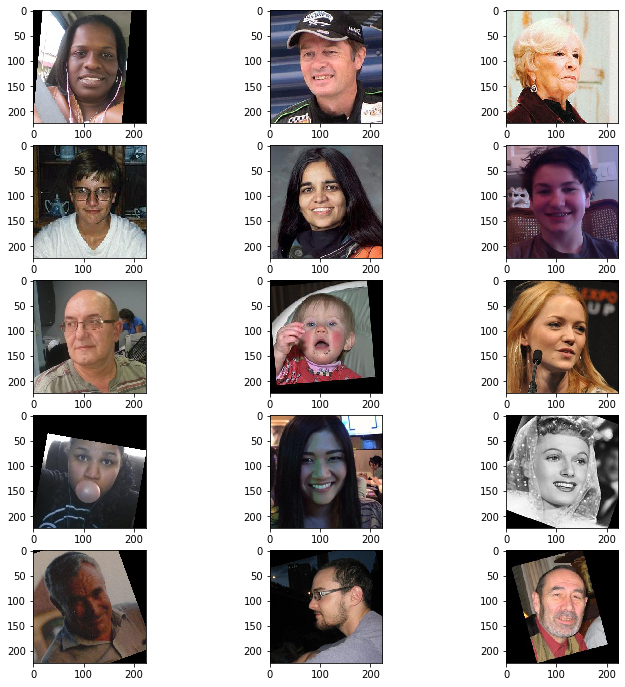

In [9]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_data[0][i])
plt.show()


# Вывод
Имеем 7.5к фотографий. Большая часть фотографмй людей возрастом между 18 и 40 годами. Есть черно-белые фотографии, смещенные и повернутые, т.е. в датасете уже предусмотрены различные "искажения" <br>
Также стоит отметить, что людям самим бывает трудно оценить точный возраст другого человека.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        subset='training',    
        class_mode='raw',
        seed=12345
    )
    return train_gen_flow
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        subset='validation',    
        class_mode='raw',
        seed=12345
    )
    return test_gen_flow
def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
   
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())    
    model.add(Dense(units=1, activation='relu'))
    optimizer=Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model
def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
        validation_data = test_data,
        batch_size=batch_size, 
        epochs=epochs, 
        steps_per_epoch=steps_per_epoch,
        validation_steps = validation_steps, 
        verbose=2, 
        shuffle=True
    )
    return model
```

Результат:

```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
WARNING:tensorflow:sample_weight modes were coerced from
  ...
  ...
    to  
    to  
  ['...']
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
WARNING:tensorflow:sample_weight modes were coerced from
  ...
  ...
    to  
    to  
  ['...']
  ['...']
Train for 356 steps, validate for 119 steps
Train for 356 steps, validate for 119 steps
Epoch 1/5
Epoch 1/5
2020-05-06 14:46:36.009532: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-05-06 14:46:36.009532: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-05-06 14:46:36.331439: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-05-06 14:46:36.331439: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 52s - loss: 188.7292 - mae: 10.0828 - val_loss: 627.6734 - val_mae: 20.0101
356/356 - 52s - loss: 188.7292 - mae: 10.0828 - val_loss: 627.6734 - val_mae: 20.0101
Epoch 2/5
Epoch 2/5
356/356 - 43s - loss: 67.6671 - mae: 6.2998 - val_loss: 134.7339 - val_mae: 8.8889
356/356 - 43s - loss: 67.6671 - mae: 6.2998 - val_loss: 134.7339 - val_mae: 8.8889
Epoch 3/5
Epoch 3/5
356/356 - 42s - loss: 37.6595 - mae: 4.7740 - val_loss: 76.7112 - val_mae: 6.5479
356/356 - 42s - loss: 37.6595 - mae: 4.7740 - val_loss: 76.7112 - val_mae: 6.5479
Epoch 4/5
Epoch 4/5
356/356 - 42s - loss: 24.2619 - mae: 3.8324 - val_loss: 88.8897 - val_mae: 6.9522
356/356 - 42s - loss: 24.2619 - mae: 3.8324 - val_loss: 88.8897 - val_mae: 6.9522
Epoch 5/5
Epoch 5/5
356/356 - 42s - loss: 16.4041 - mae: 3.1178 - val_loss: 71.5946 - val_mae: 6.4065
356/356 - 42s - loss: 16.4041 - mae: 3.1178 - val_loss: 71.5946 - val_mae: 6.4065
WARNING:tensorflow:sample_weight modes were coerced from
WARNING:tensorflow:sample_weight modes were coerced from
  ...
  ...
    to  
    to  
  ['...']
  ['...']
119/119 - 10s - loss: 71.5946 - mae: 6.4065
119/119 - 10s - loss: 71.5946 - mae: 6.4065
Test MAE: 6.4065
Test MAE: 6.4065

```


# 3. Анализ обученной модели

Для определения возраста хорошо подошла сеть ResNet c параметром `weights='imagenet'`. Для того чтобы сеть выдавала ответ в виде положительного числа, выхожным слоем используем слой типа `Dense` с функцией активации в `relu` и с 1 нейроном